# Deep Q-Networks and Their Improvements
In scenarios with large input space i.e. large discrete inputs or continous outputs, it is extremely difficult (and often physically impossible) to use Q-learning since the Q-table cannot be stored in memory. However we can still use neural networks, universal function approximators, to estimate the Q-function for the problem.

In DQN we use a single fully connected neural network that takes in the input state, pass it to our neural network to find the Q-values for all possible actions and choose the action with the highest Q-value (this serves as our policy).

This naive DQN however suffers from a problem of moving targets so we add a target network to the DQN to to provide a 'fixed' target which is updated seldomly. This helps improve the learning stability for the model.

However, the update rule for DQN (the same as Q-Learnng), has a tendency to over-estimate the Q-value (since it takes a maximum during the update).

We can counteract this systemic bias in two different ways.

## 1. Double DQN

In double DQN we use two networks to separate the process of action selection and action evaluation. We use the first network to simply pick an action, and use the second network to evaluate the value of that action. By separating these two steps we are able to mitigate the overestimation problem.

## 2. Duelling DQN

In duelling DQN, we use a single network but to overcome the systemic bias introduce two streams in the network that compete with each other. One streams calculates the state-value (V-function) while the the other calculates the advatage for each action. Then we can use these to calculate the Q-value for each action. By splitting into two streams we are successful in overcoming the overestimation problem.


# Setup & Installation

Install all required dependencies, including pytorch and gymnasium which we use for instantiating the learning and testing environment.

In [1]:
# !pip3 install numpy torch gymnasium tqdm matplotlib

In [2]:
# !pip install swig
# !pip install gym[box2d]

### Utility Functions


In [3]:
import torch
from torch import nn


def select_greedy_actions(states: torch.Tensor, q_network: nn.Module) -> torch.Tensor:
    """Select the greedy action for the current state given some Q-network."""
    _, actions = q_network(states).max(dim=1, keepdim=True)
    return actions


def evaluate_selected_actions(states: torch.Tensor,
                              actions: torch.Tensor,
                              rewards: torch.Tensor,
                              dones: torch.Tensor,
                              gamma: float,
                              q_network: nn.Module) -> torch.Tensor:
    """Compute the Q-values by evaluating the actions given the current states and Q-network."""
    next_q_values = q_network(states).gather(dim=1, index=actions)
    q_values = rewards + (gamma * next_q_values * (1 - dones))
    return q_values


def q_learning_update(states: torch.Tensor,
                      rewards: torch.Tensor,
                      dones: torch.Tensor,
                      gamma: float,
                      q_network: nn.Module) -> torch.Tensor:
    """Q-Learning update with explicitly decoupled action selection and evaluation steps."""
    actions = select_greedy_actions(states, q_network)
    q_values = evaluate_selected_actions(states, actions, rewards, dones, gamma, q_network)
    return q_values

def double_q_learning_update(states: torch.Tensor,
                             rewards: torch.Tensor,
                             dones: torch.Tensor,
                             gamma: float,
                             q_network_1: nn.Module,
                             q_network_2: nn.Module) -> torch.Tensor:
    """Double Q-Learning uses Q-network 1 to select actions and Q-network 2 to evaluate the selected actions."""
    actions = select_greedy_actions(states, q_network_1)
    q_values = evaluate_selected_actions(states, actions, rewards, dones, gamma, q_network_2)
    return q_values

## Experience Replay Buffer

We store frames while learning into a buffer and randomly sample from this buffer while training. Doing this helps reduce the temporal correlation between the actions and generally improves the learning stability of the model.

In [4]:
import collections
import typing

import numpy as np


_field_names = [
    "state",
    "action",
    "reward",
    "next_state",
    "done"
]
Experience = collections.namedtuple("Experience", field_names=_field_names)


class ExperienceReplayBuffer:
    """Fixed-size buffer to store Experience tuples."""

    def __init__(self,
                 batch_size: int,
                 buffer_size: int = None,
                 random_state: np.random.RandomState = None) -> None:
        """
        Initialize an ExperienceReplayBuffer object.

        Parameters:
        -----------
        buffer_size (int): maximum size of buffer
        batch_size (int): size of each training batch
        random_state (np.random.RandomState): random number generator.

        """
        self._batch_size = batch_size
        self._buffer_size = buffer_size
        self._buffer = collections.deque(maxlen=buffer_size)
        self._random_state = np.random.RandomState() if random_state is None else random_state

    def __len__(self) -> int:
        return len(self._buffer)

    @property
    def batch_size(self) -> int:
        """Number of experience samples per training batch."""
        return self._batch_size

    @property
    def buffer_size(self) -> int:
        """Total number of experience samples stored in memory."""
        return self._buffer_size

    def append(self, experience: Experience) -> None:
        """Add a new experience to memory."""
        self._buffer.append(experience)

    def sample(self) -> typing.List[Experience]:
        """Randomly sample a batch of experiences from memory."""
        idxs = self._random_state.randint(len(self._buffer), size=self._batch_size)
        experiences = [self._buffer[idx] for idx in idxs]
        return experiences

## DQN Agent

Next we define the DQN agent capable of becoming a DQN, Double DQN, Duelling DQN or Double-Duelling DQN agent. We define a abstract Agent class to keep the code extendable for future use.

In [5]:
import typing

import numpy as np
import torch
from torch import nn, optim
from torch.nn import functional as F


class Agent:

    def choose_action(self, state: np.array) -> int:
        """Rule for choosing an action given the current state of the environment."""
        raise NotImplementedError

    def learn(self, experiences: typing.List[Experience]) -> None:
        """Update the agent's state based on a collection of recent experiences."""
        raise NotImplementedError

    def save(self, filepath) -> None:
        """Save any important agent state to a file."""
        raise NotImplementedError

    def step(self,
             state: np.array,
             action: int,
             reward: float,
             next_state: np.array,
             done: bool) -> None:
        """Update agent's state after observing the effect of its action on the environment."""
        raise NotImplmentedError


class DeepQAgent(Agent):

    def __init__(self,
                 state_size: int,
                 action_size: int,
                 number_hidden_units: int,
                 optimizer_fn: typing.Callable[[typing.Iterable[nn.Parameter]], optim.Optimizer],
                 batch_size: int,
                 buffer_size: int,
                 epsilon_decay_schedule: typing.Callable[[int], float],
                 alpha: float,
                 gamma: float,
                 update_frequency: int,
                 double_dqn: bool = False,
                 duelling_dqn: bool = False,
                 seed: int = None) -> None:
        """
        Initialize a DeepQAgent.

        Parameters:
        -----------
        state_size (int): the size of the state space.
        action_size (int): the size of the action space.
        number_hidden_units (int): number of units in the hidden layers.
        optimizer_fn (callable): function that takes Q-network parameters and returns an optimizer.
        batch_size (int): number of experience tuples in each mini-batch.
        buffer_size (int): maximum number of experience tuples stored in the replay buffer.
        epsilon_decay_schdule (callable): function that takes episode number and returns epsilon.
        alpha (float): rate at which the target q-network parameters are updated.
        gamma (float): Controls how much that agent discounts future rewards (0 < gamma <= 1).
        update_frequency (int): frequency (measured in time steps) with which q-network parameters are updated.
        double_dqn (bool): whether to use vanilla DQN algorithm or use the Double DQN algorithm.
        seed (int): random seed

        """
        self._state_size = state_size
        self._action_size = action_size
        self._device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        # set seeds for reproducibility
        self._random_state = np.random.RandomState() if seed is None else np.random.RandomState(seed)
        if seed is not None:
            torch.manual_seed(seed)
        if torch.cuda.is_available():
            torch.backends.cudnn.deterministic = True
            torch.backends.cudnn.benchmark = False

        # initialize agent hyperparameters
        _replay_buffer_kwargs = {
            "batch_size": batch_size,
            "buffer_size": buffer_size,
            "random_state": self._random_state
        }
        self._memory = ExperienceReplayBuffer(**_replay_buffer_kwargs)
        self._epsilon_decay_schedule = epsilon_decay_schedule
        self._alpha = alpha
        self._gamma = gamma
        self._double_dqn = double_dqn
        self._duelling_dqn = duelling_dqn

        # initialize Q-Networks
        self._update_frequency = update_frequency
        self._online_q_network = self._initialize_q_network(number_hidden_units)
        self._target_q_network = self._initialize_q_network(number_hidden_units)
        self._synchronize_q_networks(self._target_q_network, self._online_q_network)
        self._online_q_network.to(self._device)
        self._target_q_network.to(self._device)

        # initialize the optimizer
        self._optimizer = optimizer_fn(self._online_q_network.parameters())

        # initialize some counters
        self._number_episodes = 0
        self._number_timesteps = 0

    def _initialize_q_network(self, number_hidden_units: int) -> nn.Module:
        """Create a neural network for approximating the action-value function."""
        # Duelling or Double-Duelling DQN
        if self._duelling_dqn:
          q_network = duelling_network(self._state_size, number_hidden_units, self._action_size)
          return q_network
        # Simple or Double DQN
        q_network = nn.Sequential(
            nn.Linear(in_features=self._state_size, out_features=number_hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=number_hidden_units, out_features=number_hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=number_hidden_units, out_features=self._action_size)
        )
        return q_network

    @staticmethod
    def _soft_update_q_network_parameters(q_network_1: nn.Module,
                                          q_network_2: nn.Module,
                                          alpha: float) -> None:
        """In-place, soft-update of q_network_1 parameters with parameters from q_network_2."""
        for p1, p2 in zip(q_network_1.parameters(), q_network_2.parameters()):
            p1.data.copy_(alpha * p2.data + (1 - alpha) * p1.data)

    @staticmethod
    def _synchronize_q_networks(q_network_1: nn.Module, q_network_2: nn.Module) -> None:
        """In place, synchronization of q_network_1 and q_network_2."""
        q_network_1.load_state_dict(q_network_2.state_dict())

    def _uniform_random_policy(self, state: torch.Tensor) -> int:
        """Choose an action uniformly at random."""
        return self._random_state.randint(self._action_size)

    def _greedy_policy(self, state: torch.Tensor) -> int:
        """Choose an action that maximizes the action_values given the current state."""
        action = (self._online_q_network(state)
                      .argmax()
                      .cpu()  # action_values might reside on the GPU!
                      .item())
        return action

    def _epsilon_greedy_policy(self, state: torch.Tensor, epsilon: float) -> int:
        """With probability epsilon explore randomly; otherwise exploit knowledge optimally."""
        if self._random_state.random() < epsilon:
            action = self._uniform_random_policy(state)
        else:
            action = self._greedy_policy(state)
        return action

    def choose_action(self, state: np.array) -> int:
        """
        Return the action for given state as per current policy.

        Parameters:
        -----------
        state (np.array): current state of the environment.

        Return:
        --------
        action (int): an integer representing the chosen action.

        """
        # need to reshape state array and convert to tensor
        state_tensor = (torch.from_numpy(state)
                             .unsqueeze(dim=0)
                             .to(self._device))

        # choose uniform at random if agent has insufficient experience
        if not self.has_sufficient_experience():
            action = self._uniform_random_policy(state_tensor)
        else:
            epsilon = self._epsilon_decay_schedule(self._number_episodes)
            action = self._epsilon_greedy_policy(state_tensor, epsilon)
        return action

    def learn(self, experiences: typing.List[Experience]) -> None:
        """Update the agent's state based on a collection of recent experiences."""

        states, actions, rewards, next_states, dones = (torch.Tensor(np.array(vs)).to(self._device) for vs in zip(*experiences))

        # need to add second dimension to some tensors
        actions = (actions.long()
                          .unsqueeze(dim=1))
        rewards = rewards.unsqueeze(dim=1)
        dones = dones.unsqueeze(dim=1)

        if self._double_dqn:
            target_q_values = double_q_learning_update(next_states,
                                                       rewards,
                                                       dones,
                                                       self._gamma,
                                                       self._online_q_network,
                                                       self._target_q_network)
        else:
            target_q_values = q_learning_update(next_states,
                                                rewards,
                                                dones,
                                                self._gamma,
                                                self._target_q_network)

        online_q_values = (self._online_q_network(states)
                               .gather(dim=1, index=actions))

        # compute the mean squared loss
        loss = F.mse_loss(online_q_values, target_q_values)

        # updates the parameters of the online network
        self._optimizer.zero_grad()
        loss.backward()
        self._optimizer.step()

        self._soft_update_q_network_parameters(self._target_q_network,
                                               self._online_q_network,
                                               self._alpha)

    def has_sufficient_experience(self) -> bool:
        """True if agent has enough experience to train on a batch of samples; False otherwise."""
        return len(self._memory) >= self._memory.batch_size

    def save(self, filepath: str) -> None:
        """
        Saves the state of the DeepQAgent.

        Parameters:
        -----------
        filepath (str): filepath where the serialized state should be saved.

        Notes:
        ------
        The method uses `torch.save` to serialize the state of the q-network,
        the optimizer, as well as the dictionary of agent hyperparameters.

        """
        checkpoint = {
            "q-network-state": self._online_q_network.state_dict(),
            "optimizer-state": self._optimizer.state_dict(),
            "agent-hyperparameters": {
                "alpha": self._alpha,
                "batch_size": self._memory.batch_size,
                "buffer_size": self._memory.buffer_size,
                "gamma": self._gamma,
                "update_frequency": self._update_frequency
            }
        }

        torch.save(checkpoint, filepath)

    def step(self,
             state: np.array,
             action: int,
             reward: float,
             next_state: np.array,
             done: bool) -> None:
        """
        Updates the agent's state based on feedback received from the environment.

        Parameters:
        -----------
        state (np.array): the previous state of the environment.
        action (int): the action taken by the agent in the previous state.
        reward (float): the reward received from the environment.
        next_state (np.array): the resulting state of the environment following the action.
        done (bool): True is the training episode is finised; false otherwise.

        """
        experience = Experience(state, action, reward, next_state, done)
        self._memory.append(experience)

        if done:
            self._number_episodes += 1
        else:
            self._number_timesteps += 1

            # every so often the agent should learn from experiences
            if self._number_timesteps % self._update_frequency == 0 and self.has_sufficient_experience():
                experiences = self._memory.sample()
                self.learn(experiences)

## Duelling DQN Architecture

As described in the introduction we have two streams in the neural network, one to estimate the state-value and another to find the advantage for each action.

In [6]:
class duelling_network(nn.Module):
  def __init__(self, input_size, number_hidden_units, output_size):
    super(duelling_network, self).__init__()
    self._dense = nn.Sequential(
            nn.Linear(in_features=input_size, out_features=number_hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=number_hidden_units, out_features=number_hidden_units),
            nn.ReLU(),
        )

    self._value_head = nn.Linear(in_features=number_hidden_units, out_features=1)
    self._advantage_head = nn.Linear(in_features=number_hidden_units, out_features=output_size)

  def forward(self, x):
    dense_out = self._dense(x)

    value = self._value_head(dense_out)
    adv = self._advantage_head(dense_out)

    q_values = value + adv - adv.mean(1).reshape(-1,1)

    return q_values


## Training

In [7]:
import collections
import typing
from tqdm.notebook import tqdm

import gymnasium as gym


def _train_for_at_most(agent: Agent, env: gym.Env, max_timesteps: int) -> int:
    """Train agent for a maximum number of timesteps."""
    state, _ = env.reset()
    print(type(state))
    score = 0
    for t in range(max_timesteps):
        action = agent.choose_action(state)
        next_state, reward, terminated, truncated, info = env.step(action)
        done = terminated or truncated
        agent.step(state, action, reward, next_state, done)
        state = next_state
        score += reward
        if done:
            break
    return score, reward


def _train_until_done(agent: Agent, env: gym.Env) -> float:
    """Train the agent until the current episode is complete."""
    state, _ = env.reset()
    score = 0
    done = False
    while not done:
        action = agent.choose_action(state)
        next_state, reward, terminated, truncated, info = env.step(action)
        done = terminated or truncated
        agent.step(state, action, reward, next_state, done)
        state = next_state
        score += reward
    return score, reward


def train(agent: Agent,
          env: gym.Env,
          checkpoint_filepath: str,
          target_score: float,
          number_episodes: int,
          maximum_timesteps=None) -> typing.List[float]:
    """
    Reinforcement learning training loop.

    Parameters:
    -----------
    agent (Agent): an agent to train.
    env (gym.Env): an environment in which to train the agent.
    checkpoint_filepath (str): filepath used to save the state of the trained agent.
    number_episodes (int): maximum number of training episodes.
    maximum_timsteps (int): maximum number of timesteps per episode.

    Returns:
    --------
    scores (list): collection of episode scores from training.

    """
    total_scores, final_scores = [], []
    most_recent_scores = collections.deque(maxlen=100)
    for i in tqdm(range(number_episodes)):
        if maximum_timesteps is None:
            score, last_score = _train_until_done(agent, env)
        else:
            score, last_score = _train_for_at_most(agent, env, maximum_timesteps)
        total_scores.append(score)
        final_scores.append(last_score)

        most_recent_scores.append(score)

        average_score = sum(most_recent_scores) / len(most_recent_scores)
        if average_score >= target_score:
            print(f"\nEnvironment solved in {i:d} episodes!\tAverage Score: {average_score:.2f}")
            agent.save(checkpoint_filepath)
            break
        if (i + 1) % 100 == 0:
            print(f"\rEpisode {i + 1}\tAverage Score: {average_score:.2f}")

    return total_scores

In [8]:
env = gym.make('LunarLander-v2')

### Greedy Epsilon Search

In [9]:
def power_decay_schedule(episode_number: int,
                         decay_factor: float,
                         minimum_epsilon: float) -> float:
    """Power decay schedule found in other practical applications."""
    return max(decay_factor**episode_number, minimum_epsilon)

_epsilon_decay_schedule_kwargs = {
    "decay_factor": 0.99,
    "minimum_epsilon": 1e-2,
}
epsilon_decay_schedule = lambda n: power_decay_schedule(n, **_epsilon_decay_schedule_kwargs)

In [10]:
from torch import optim


_optimizer_kwargs = {
    "lr": 1e-3,
    "betas": (0.9, 0.999),
    "eps": 1e-08,
    "weight_decay": 0,
    "amsgrad": False,
}
optimizer_fn = lambda parameters: optim.Adam(parameters, **_optimizer_kwargs)

## DQN

In [11]:
_agent_kwargs = {
    "state_size": env.observation_space.shape[0],
    "action_size": env.action_space.n,
    "number_hidden_units": 64,
    "optimizer_fn": optimizer_fn,
    "epsilon_decay_schedule": epsilon_decay_schedule,
    "batch_size": 64,
    "buffer_size": 100000,
    "alpha": 1e-3,
    "gamma": 0.99,
    "update_frequency": 4,
    "double_dqn": False,  # True uses Double DQN; False uses DQN
    "duelling_dqn": True, # True use Duelling DQN; False uses DQN
    "seed": None,
}
dqn_agent = DeepQAgent(**_agent_kwargs)

dqn_scores = train(dqn_agent,
                   env,
                   "dqn-checkpoint.pth",
                   number_episodes=2500,
                   target_score=250)

torch.save(dqn_agent._online_q_network.state_dict(), "DQN.pth")

  0%|          | 0/2500 [00:00<?, ?it/s]

Episode 100	Average Score: -187.70
Episode 200	Average Score: -82.28
Episode 300	Average Score: -21.57
Episode 400	Average Score: 14.91
Episode 500	Average Score: 127.06
Episode 600	Average Score: 218.57
Episode 700	Average Score: 222.79
Episode 800	Average Score: 237.96

Environment solved in 831 episodes!	Average Score: 250.39


## Double DQN

In [17]:
_agent_kwargs = {
    "state_size": env.observation_space.shape[0],
    "action_size": env.action_space.n,
    "number_hidden_units": 64,
    "optimizer_fn": optimizer_fn,
    "epsilon_decay_schedule": epsilon_decay_schedule,
    "batch_size": 64,
    "buffer_size": 100000,
    "alpha": 1e-3,
    "gamma": 0.99,
    "update_frequency": 4,
    "double_dqn": True,  # True uses Double DQN; False uses DQN
    "duelling_dqn": True, # True use Duelling DQN; False uses DQN
    "seed": None,
}
double_dqn_agent = DeepQAgent(**_agent_kwargs)

double_dqn_scores = train(double_dqn_agent,
                          env,
                          "double-dqn-checkpoint.pth",
                          number_episodes=2500,
                          target_score=275)

torch.save(double_dqn_agent._online_q_network.state_dict(), "Double_DQN.pth")

  0%|          | 0/2500 [00:00<?, ?it/s]

Episode 100	Average Score: -181.60
Episode 200	Average Score: -87.42
Episode 300	Average Score: 57.91
Episode 400	Average Score: 145.14
Episode 500	Average Score: 161.63
Episode 600	Average Score: 196.12
Episode 700	Average Score: 236.31
Episode 800	Average Score: 221.15
Episode 900	Average Score: 204.40
Episode 1000	Average Score: 200.54
Episode 1100	Average Score: 212.75
Episode 1200	Average Score: 235.67
Episode 1300	Average Score: 240.49
Episode 1400	Average Score: 240.92
Episode 1500	Average Score: 235.41
Episode 1600	Average Score: 239.91
Episode 1700	Average Score: 227.29
Episode 1800	Average Score: 250.17
Episode 1900	Average Score: 253.07
Episode 2000	Average Score: 260.54
Episode 2100	Average Score: 259.35
Episode 2200	Average Score: 257.50
Episode 2300	Average Score: 264.25
Episode 2400	Average Score: 268.93
Episode 2500	Average Score: 269.89


## Duelling DQN

In [18]:
_agent_kwargs = {
    "state_size": env.observation_space.shape[0],
    "action_size": env.action_space.n,
    "number_hidden_units": 64,
    "optimizer_fn": optimizer_fn,
    "epsilon_decay_schedule": epsilon_decay_schedule,
    "batch_size": 64,
    "buffer_size": 100000,
    "alpha": 1e-3,
    "gamma": 0.99,
    "update_frequency": 4,
    "double_dqn": False,  # True uses Double DQN; False uses DQ
    "duelling_dqn": True, # True use Duelling DQN; False uses DQN,
    "seed": None,
}
duelling_dqn_agent = DeepQAgent(**_agent_kwargs)

duelling_dqn_scores = train(duelling_dqn_agent,
                          env,
                          "duelling-dqn-checkpoint.pth",
                          number_episodes=2500,
                          target_score=275)

torch.save(duelling_dqn_agent._online_q_network.state_dict(), "Duelling_DQN.pth")

  0%|          | 0/2500 [00:00<?, ?it/s]

Episode 100	Average Score: -160.42
Episode 200	Average Score: -85.31
Episode 300	Average Score: -59.76
Episode 400	Average Score: -4.17
Episode 500	Average Score: 38.19
Episode 600	Average Score: 111.92
Episode 700	Average Score: 188.50
Episode 800	Average Score: 213.70
Episode 900	Average Score: 211.62
Episode 1000	Average Score: 236.49
Episode 1100	Average Score: 222.13
Episode 1200	Average Score: 99.05
Episode 1300	Average Score: 143.96
Episode 1400	Average Score: 158.66
Episode 1500	Average Score: 198.34
Episode 1600	Average Score: 229.67
Episode 1700	Average Score: 224.32
Episode 1800	Average Score: 259.78
Episode 1900	Average Score: 261.12
Episode 2000	Average Score: 259.61
Episode 2100	Average Score: 224.91
Episode 2200	Average Score: 260.88
Episode 2300	Average Score: 264.80
Episode 2400	Average Score: 255.23
Episode 2500	Average Score: 265.95


## Double Duelling DQN

In [19]:
_agent_kwargs = {
    "state_size": env.observation_space.shape[0],
    "action_size": env.action_space.n,
    "number_hidden_units": 64,
    "optimizer_fn": optimizer_fn,
    "epsilon_decay_schedule": epsilon_decay_schedule,
    "batch_size": 64,
    "buffer_size": 100000,
    "alpha": 1e-3,
    "gamma": 0.99,
    "update_frequency": 4,
    "double_dqn": True,  # True uses Double DQN; False uses DQN
    "duelling_dqn": True, # True use Duelling DQN; False uses DQN,
    "seed": None,
}
double_duelling_dqn_agent = DeepQAgent(**_agent_kwargs)

double_duelling_dqn_scores = train(double_duelling_dqn_agent,
                          env,
                          "duelling-dqn-checkpoint.pth",
                          number_episodes=2500,
                          target_score=275)

torch.save(double_duelling_dqn_agent._online_q_network.state_dict(), "Double_Duelling_DQN.pth")

  0%|          | 0/2500 [00:00<?, ?it/s]

Episode 100	Average Score: -172.97
Episode 200	Average Score: -57.15
Episode 300	Average Score: 31.19
Episode 400	Average Score: 129.18
Episode 500	Average Score: 184.23
Episode 600	Average Score: 210.23
Episode 700	Average Score: 214.12
Episode 800	Average Score: 205.57
Episode 900	Average Score: 225.32
Episode 1000	Average Score: 226.52
Episode 1100	Average Score: 246.47
Episode 1200	Average Score: 243.77
Episode 1300	Average Score: 257.29
Episode 1400	Average Score: 262.17
Episode 1500	Average Score: 248.31
Episode 1600	Average Score: 259.87
Episode 1700	Average Score: 244.01
Episode 1800	Average Score: 259.20
Episode 1900	Average Score: 263.89
Episode 2000	Average Score: 250.92
Episode 2100	Average Score: 264.79
Episode 2200	Average Score: 270.25
Episode 2300	Average Score: 267.27
Episode 2400	Average Score: 266.91
Episode 2500	Average Score: 258.59


In [20]:
env.close()

## Results

Plot the training results, and save the training results for later use

In [21]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [22]:
dqn_scores = pd.Series(dqn_scores, name="scores")
double_dqn_scores = pd.Series(double_dqn_scores, name="scores")
duelling_dqn_scores = pd.Series(duelling_dqn_scores, name="scores")
double_duelling_dqn_scores = pd.Series(double_duelling_dqn_scores, name="scores")

Text(0, 0.5, 'Score')

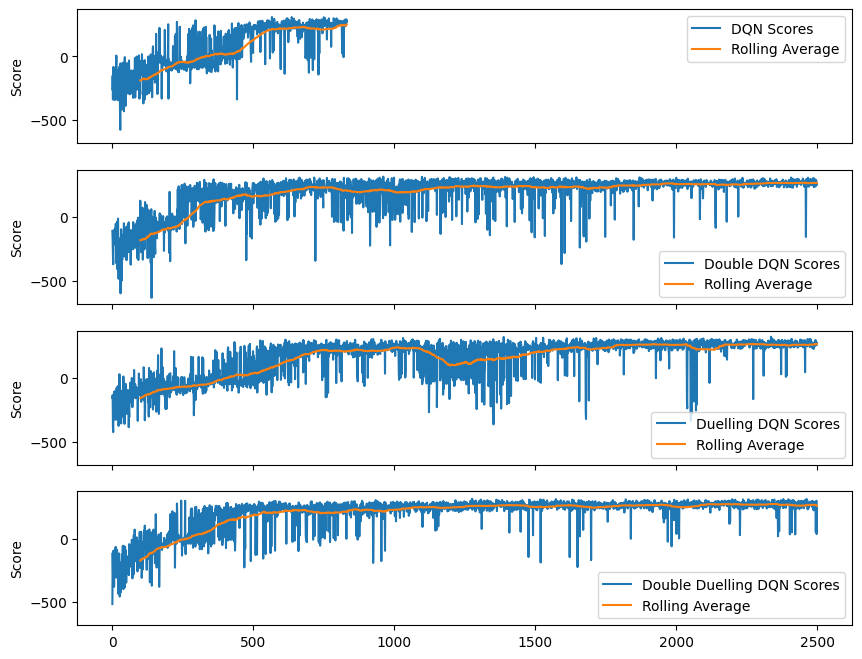

In [23]:
fig, axes = plt.subplots(4, 1, figsize=(10, 8), sharex=True, sharey=True)

dqn_scores.plot(ax=axes[0], label="DQN Scores")
(dqn_scores.rolling(window=100)
               .mean()
               .rename("Rolling Average")
               .plot(ax=axes[0]))
axes[0].legend()
axes[0].set_ylabel("Score")

double_dqn_scores.plot(ax=axes[1], label="Double DQN Scores")
(double_dqn_scores.rolling(window=100)
                    .mean()
                    .rename("Rolling Average")
                    .plot(ax=axes[1]))
axes[1].legend()
axes[1].set_ylabel("Score")
axes[1].set_xlabel("Episode Number")

duelling_dqn_scores.plot(ax=axes[2], label="Duelling DQN Scores")
(duelling_dqn_scores.rolling(window=100)
               .mean()
               .rename("Rolling Average")
               .plot(ax=axes[2]))
axes[2].legend()
axes[2].set_ylabel("Score")

double_duelling_dqn_scores.plot(ax=axes[3], label="Double Duelling DQN Scores")
(double_duelling_dqn_scores.rolling(window=100)
               .mean()
               .rename("Rolling Average")
               .plot(ax=axes[3]))
axes[3].legend()
axes[3].set_ylabel("Score")

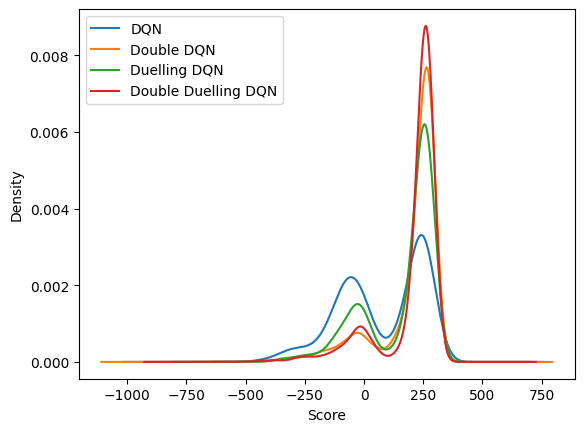

In [24]:
fig, ax = plt.subplots(1,1)
dqn_scores.plot(kind="kde", ax=ax, label="DQN")
double_dqn_scores.plot(kind="kde", ax=ax, label="Double DQN")
duelling_dqn_scores.plot(kind="kde", ax=ax, label="Duelling DQN")
double_duelling_dqn_scores.plot(kind="kde", ax=ax, label="Double Duelling DQN")
ax.set_xlabel("Score")
ax.legend()

## Testing

Test the given models for a 500 episodes each.


In [25]:
# !pip install moviepy

In [26]:
def plotTestResults(title: str,
                    total_rewards: list[float],
                    final_rewards: list[float]):
  """Plot the total and final rewards from training"""
  plt.figure(1)
  plt.title(title)
  plt.xlabel('Episode')
  plt.ylabel('Total & Final Rewards')
  plt.plot(total_rewards, label='Total Rewards')
  plt.plot(final_rewards, label='Final Rewards')
  plt.legend()
  plt.show()


def runTest(agent: tuple[str, Agent],
            score_threshold: int,
            episode_index: int,
            total_rewards: list[float],
            final_rewards: list[float]):

  """Run an episode using the given model, save a video of the episode if the
  total reward is higher than the score threshold.
  """
  state, _ = envTest.reset()
  done, total_reward = False, 0
  while not done:
      action = agent[1].choose_action(state)
      state, reward, terminated, truncated, _ = envTest.step(action)
      done = terminated or truncated
      total_reward += reward

  if total_reward > score_threshold:
    save_video(
            envTest.render(),
            "videos",
            fps=envTest.metadata["render_fps"],
            episode_index=episode_index,
            name_prefix = agent[0]
          )

  total_rewards.append(total_reward)
  final_rewards.append(reward)
  if reward >= 100: return 1
  return 0


def Test(agent, score_threshold, test_eps, total_rewards, final_rewards):
  """ Test the given model"""
  success = 0
  for i in tqdm(range(test_eps)):
    success += runTest(agent, score_threshold, i, total_rewards, final_rewards)
  plotTestResults(agent[0], total_rewards, final_rewards)
  print(f"Success Rate: {(success) / test_eps  * 100:.2f}%")


  0%|          | 0/500 [00:00<?, ?it/s]

Moviepy - Building video /content/videos/DQN-episode-64.mp4.
Moviepy - Writing video /content/videos/DQN-episode-64.mp4




t:  92%|█████████▏| 197/213 [00:00<00:00, 217.49it/s, now=None]
                                                               

Moviepy - Done !
Moviepy - video ready /content/videos/DQN-episode-64.mp4


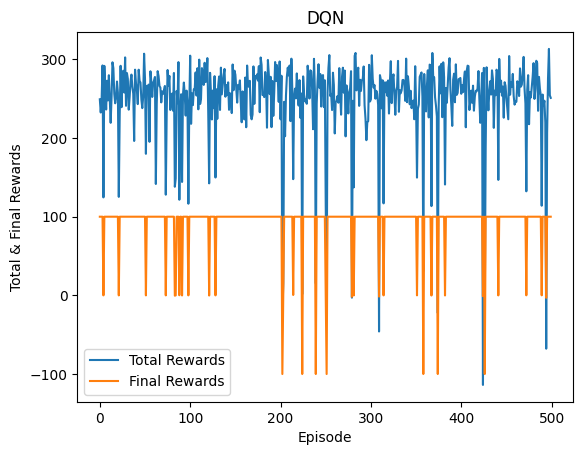

Success Rate: 93.40%


  0%|          | 0/500 [00:00<?, ?it/s]

Moviepy - Building video /content/videos/Double_DQN-episode-1.mp4.
Moviepy - Writing video /content/videos/Double_DQN-episode-1.mp4




t:  93%|█████████▎| 276/296 [00:01<00:00, 207.51it/s, now=None]
                                                               

Moviepy - Done !
Moviepy - video ready /content/videos/Double_DQN-episode-1.mp4
Moviepy - Building video /content/videos/Double_DQN-episode-125.mp4.
Moviepy - Writing video /content/videos/Double_DQN-episode-125.mp4




t: 100%|██████████| 214/214 [00:00<00:00, 218.75it/s, now=None]
                                                               

Moviepy - Done !
Moviepy - video ready /content/videos/Double_DQN-episode-125.mp4


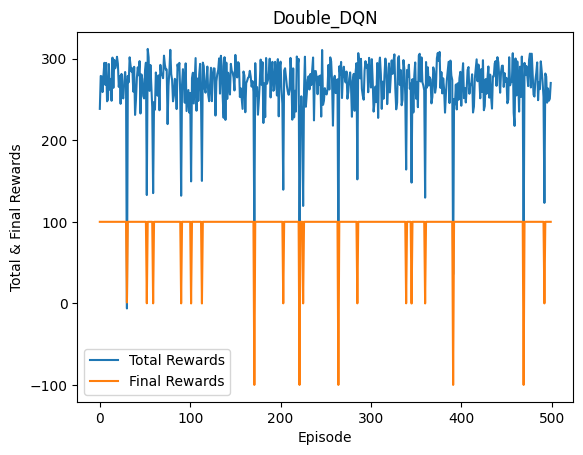

Success Rate: 96.40%


  0%|          | 0/500 [00:00<?, ?it/s]

Moviepy - Building video /content/videos/Duelling_DQN-episode-8.mp4.
Moviepy - Writing video /content/videos/Duelling_DQN-episode-8.mp4




t:  95%|█████████▍| 227/239 [00:01<00:00, 215.99it/s, now=None]
                                                               

Moviepy - Done !
Moviepy - video ready /content/videos/Duelling_DQN-episode-8.mp4
Moviepy - Building video /content/videos/Duelling_DQN-episode-27.mp4.
Moviepy - Writing video /content/videos/Duelling_DQN-episode-27.mp4




t:  92%|█████████▏| 206/225 [00:00<00:00, 211.07it/s, now=None]
                                                               

Moviepy - Done !
Moviepy - video ready /content/videos/Duelling_DQN-episode-27.mp4


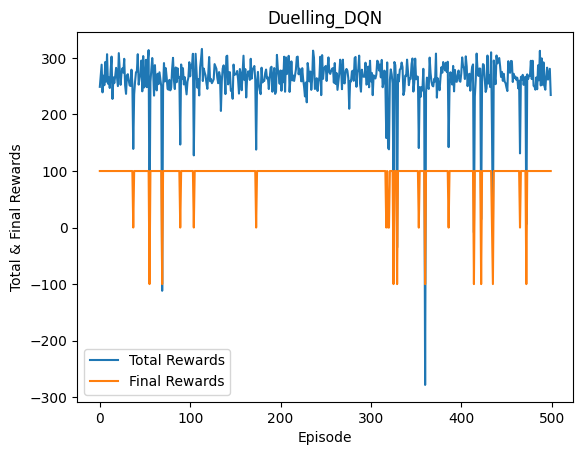

Success Rate: 96.00%


  0%|          | 0/500 [00:00<?, ?it/s]

Moviepy - Building video /content/videos/Double Duelling_DQN-episode-8.mp4.
Moviepy - Writing video /content/videos/Double Duelling_DQN-episode-8.mp4




t:  95%|█████████▍| 245/258 [00:01<00:00, 131.84it/s, now=None]
                                                               

Moviepy - Done !
Moviepy - video ready /content/videos/Double Duelling_DQN-episode-8.mp4
Moviepy - Building video /content/videos/Double Duelling_DQN-episode-125.mp4.
Moviepy - Writing video /content/videos/Double Duelling_DQN-episode-125.mp4




t:  98%|█████████▊| 220/224 [00:00<00:00, 208.50it/s, now=None]
                                                               

Moviepy - Done !
Moviepy - video ready /content/videos/Double Duelling_DQN-episode-125.mp4


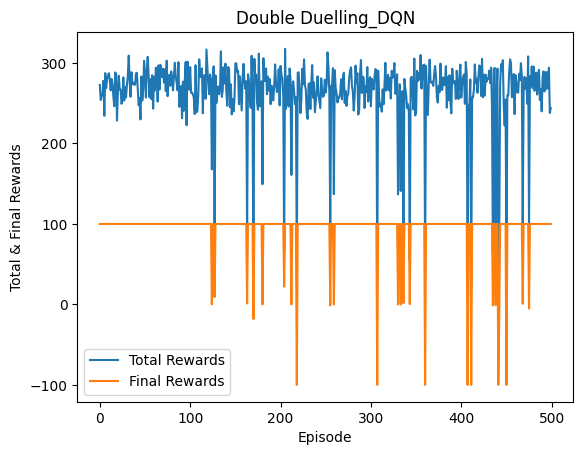

Success Rate: 95.00%


In [27]:
from gymnasium.utils.save_video import save_video
import matplotlib.pyplot as plt
import pickle

envTest = gym.make('LunarLander-v2', render_mode='rgb_array_list')

dqn_agent._online_q_network.eval()
double_dqn_agent._online_q_network.eval()
duelling_dqn_agent._online_q_network.eval()
double_duelling_dqn_agent._online_q_network.eval()

scores = [
    dqn_scores,
    double_dqn_scores,
    duelling_dqn_scores,
    double_duelling_dqn_scores
]

for i, agent in enumerate([
    ("DQN", dqn_agent),
    ("Double_DQN", double_dqn_agent),
    ("Duelling_DQN", duelling_dqn_agent),
    ("Double Duelling_DQN", double_duelling_dqn_agent)
  ]):

  total_rewards, final_rewards = [], []
  Test(agent, 275, 500, total_rewards, final_rewards)
  data = {
      "train_rewards": scores[i],
      "test_total_rewards": total_rewards,
      "test_final_rewards": final_rewards
  }
  with open(f"{agent[0]}.pkl", "wb") as f:
    pickle.dump(data, f)

envTest.close()